In [4]:
import torch
import torch.nn as nn
import nussl
from nussl.datasets import transforms as nussl_tfm
from nussl.ml.networks.modules import BatchNorm, RecurrentStack, Embedding, STFT, LearnedFilterBank, AmplitudeToDB
from models.MaskInference import MaskInference
from models.UNet import UNetSpect
from models.Filterbank import Filterbank
from utils import utils, data
from pathlib import Path
import yaml, argparse
import numpy as np
import matplotlib.pyplot as plt

In [5]:
#Load yaml configs into configs dictionary
with open('config/test_filterbank.yml','r') as f:
    configs = yaml.safe_load(f)
    f.close()

In [6]:
utils.logger()
device = 'cuda' if torch.cuda.is_available() else 'cpu'

stft_params = nussl.STFTParams(**configs['stft_params'])

#############CHANGE FOR WAVEFORM##################
tfm = nussl_tfm.Compose([
    nussl_tfm.SumSources([['bass', 'drums', 'other']]),
    nussl_tfm.GetAudio(),
    nussl_tfm.ToSeparationModel(),
])

#############CHANGE FOR WAVEFORM##################
train_data = data.on_the_fly(None, transform=tfm, fg_path=configs['test_folder'], **configs['train_generator_params'])
train_dataloader = torch.utils.data.DataLoader(train_data, num_workers=1, batch_size=configs['batch_size'])

val_data = data.on_the_fly(None, transform=tfm, fg_path=configs['valid_folder'], **configs['valid_generator_params'])
val_dataloader = torch.utils.data.DataLoader(val_data, num_workers=1, batch_size=configs['batch_size'])

In [7]:
train_data[0]

{'index': 0,
 'mix_audio': tensor([[ 0.0000,  0.0011,  0.0022,  ..., -0.0025, -0.0012,  0.0000]],
        dtype=torch.float64),
 'source_audio': tensor([[[ 0.0000,  0.0000],
          [ 0.0006,  0.0005],
          [ 0.0012,  0.0010],
          ...,
          [-0.0016, -0.0008],
          [-0.0007, -0.0004],
          [ 0.0000, -0.0000]]], dtype=torch.float64)}

In [8]:
loss_type = configs['loss_type']
loss_dict = {'L1': nussl.ml.train.loss.L1Loss,
             'L2': nussl.ml.train.loss.MSELoss,
             'MSE': nussl.ml.train.loss.MSELoss,}
assert loss_type in loss_dict.keys(), f'Loss type must be one of {loss_dict.keys()}'
loss_fn = loss_dict[loss_type]()

In [9]:
def train_step(engine, batch):
    optimizer.zero_grad()
    
    #Forward pass
    output = model(batch)
    loss = loss_fn(output['audio'],batch['source_audio'])
    
    #Backward pass
    loss.backward()
    optimizer.step()
    
    loss_vals = {'loss':loss.item()}
    
    return loss_vals

def val_step(engine, batch):
    with torch.no_grad():
        output = model(batch)
    loss = loss_fn(output['audio'],batch['source_audio'])  
    loss_vals = {'loss':loss.item()}
    return loss_vals

In [10]:
model_type = configs['model_type']
model_dict = {'Mask': MaskInference,
              'UNet': UNetSpect,
              'Filterbank':Filterbank
             }
assert model_type in model_dict.keys(), f'Model type must be one of {model_dict.keys()}'
#Set up the model and optimizer
if model_type=='Mask':
    model = MaskInference.build(stft_params.window_length//2+1, **configs['model_params']).to(device)
elif model_type=='UNet':
    model = UNetSpect.build(**configs['model_params']).to(device)
elif model_type=='Filterbank':
    model = Filterbank.build(**configs['model_params']).to(device)
    
optimizer = torch.optim.Adam(model.parameters(), **configs['optimizer_params'])

In [11]:
# Create nussl ML engine
trainer, validator = nussl.ml.train.create_train_and_validation_engines(train_step, val_step, device=device)

# Save model outputs
checkpoint_folder = Path('models/'+configs['save_name']).absolute()

# Adding handlers from nussl that print out details about model training
# run the validation step, and save the models.
nussl.ml.train.add_stdout_handler(trainer, validator)
nussl.ml.train.add_validate_and_checkpoint(checkpoint_folder, model, optimizer, train_data, trainer, val_dataloader, validator)
nussl.ml.train.add_progress_bar_handler(trainer, validator)

/SFS/user/ry/stonekev/miniconda3/envs/audio/lib/python3.10/site-packages/ignite/contrib/handlers/tqdm_logger.py:127: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [13]:
#trainer.run(train_dataloader, **configs['train_params'])

In [14]:
for batch in train_dataloader:
    batch=batch
    break
    
for key in batch:
    if torch.is_tensor(batch[key]):
        batch[key] = batch[key].float().to(device)    

In [15]:
batch['mix_audio'].shape

torch.Size([10, 1, 220500])

In [16]:
outputs = model(batch)

In [44]:
batch['mix_audio'].max()

tensor(1.)

In [42]:
outputs['audio'].shape

torch.Size([10, 1, 220500, 2])

In [43]:
outputs['audio'].max()

tensor(43.7609, grad_fn=<MaxBackward1>)

In [18]:
nussl.ml.register_module(Filterbank)

In [39]:
separator = nussl.separation.deep.DeepAudioEstimation(
    nussl.AudioSignal(), model_path='models/'+configs['save_name']+'/checkpoints/best.model.pth',
    device=device,
)

/SFS/user/ry/stonekev/miniconda3/envs/audio/lib/python3.10/site-packages/nussl/separation/base/separation_base.py:73: UserWarning: input_audio_signal has no data!
  warnings.warn('input_audio_signal has no data!')
/SFS/user/ry/stonekev/miniconda3/envs/audio/lib/python3.10/site-packages/nussl/core/audio_signal.py:455: UserWarning: Initializing STFT with data that is non-complex. This might lead to weird results!
  warnings.warn('Initializing STFT with data that is non-complex. '


In [40]:
#Test on the data
test_folder = configs['test_folder']
test_data = data.mixer(None, transform=None, fg_path=configs['test_folder'], num_mixtures=50, coherent_prob=1.0, duration=5)

item = test_data[5]
separator.audio_signal = item['mix']

In [21]:
input_data = separator._get_input_data_for_model()

In [22]:
input_data['mix_audio'].shape

torch.Size([1, 1, 220500])

In [28]:
item['mix']

In [29]:
estimates = separator()
#estimates.append(item['mix'] - estimates[0])

In [30]:
from utils import viz

In [34]:
estimates

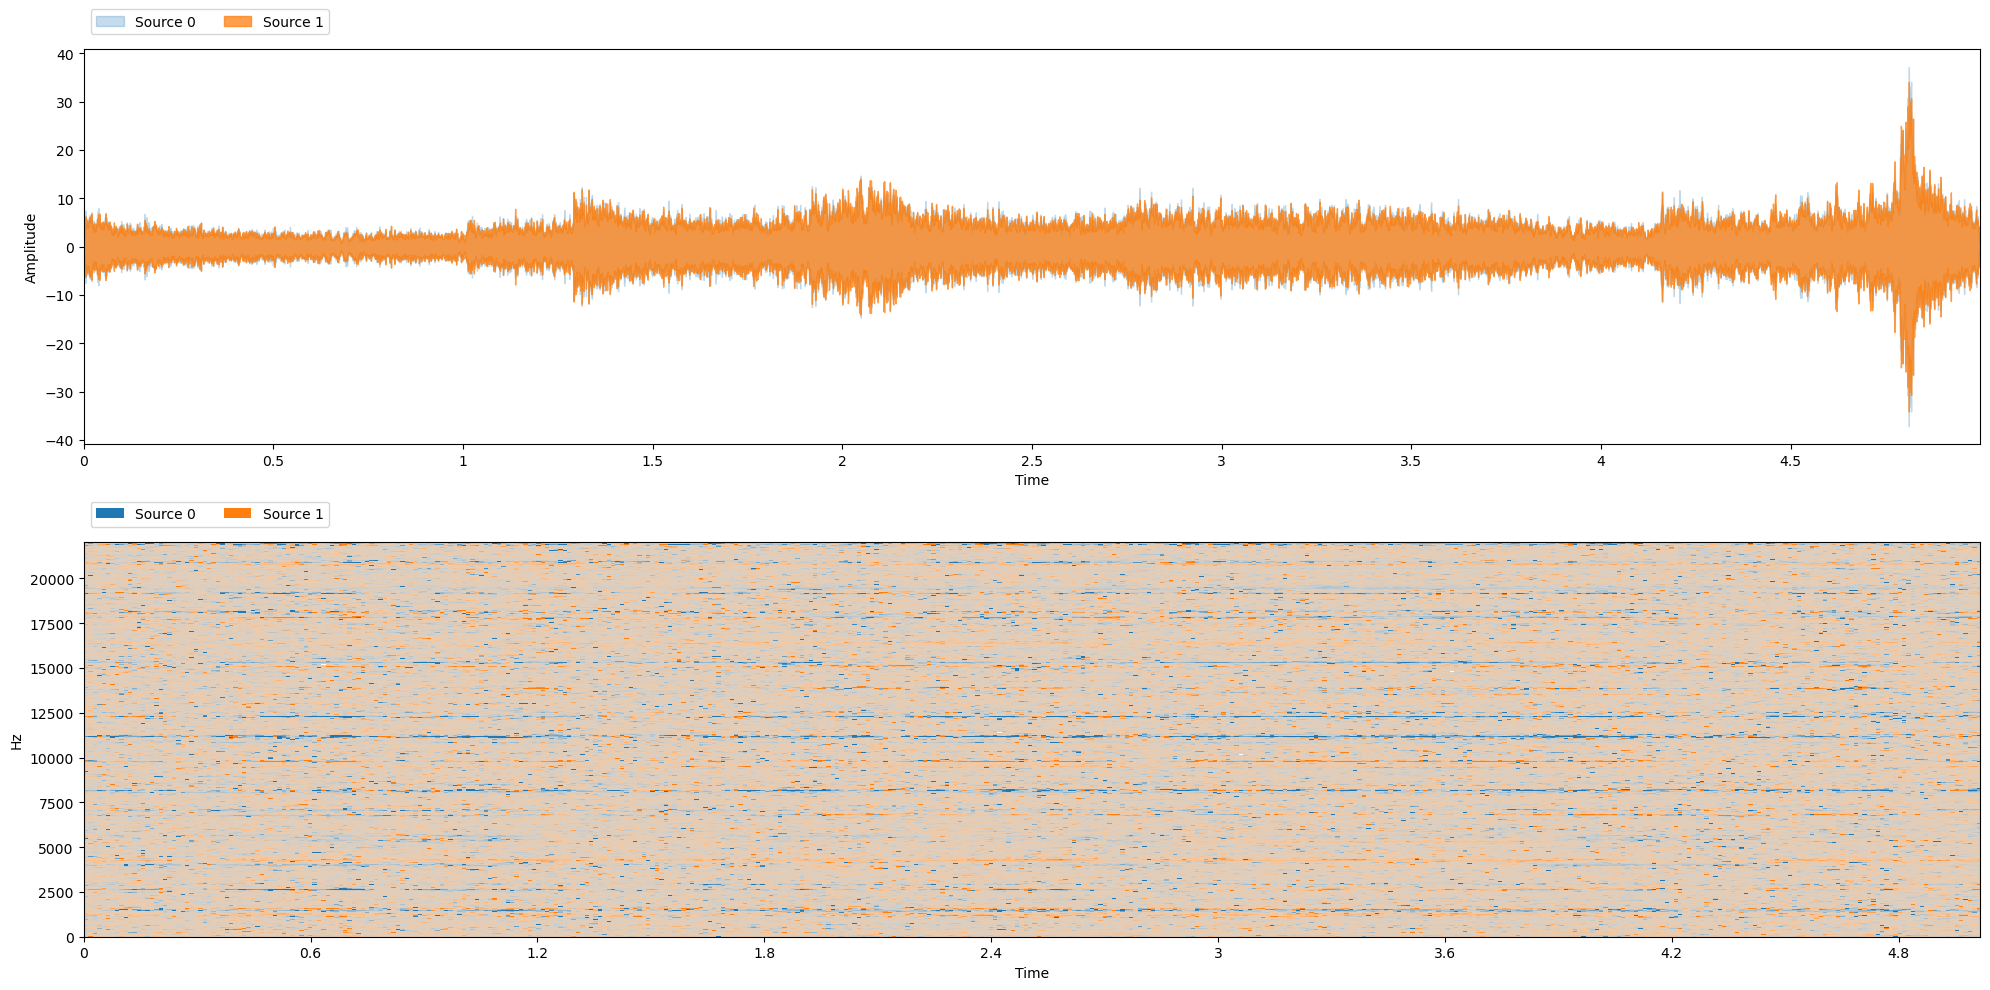


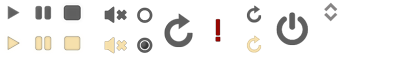
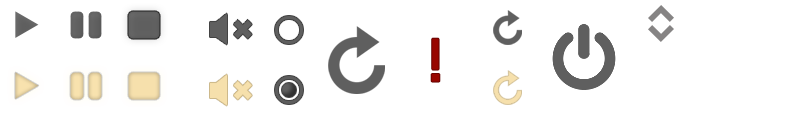
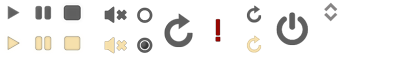

In [38]:
viz.show_sources(estimates)

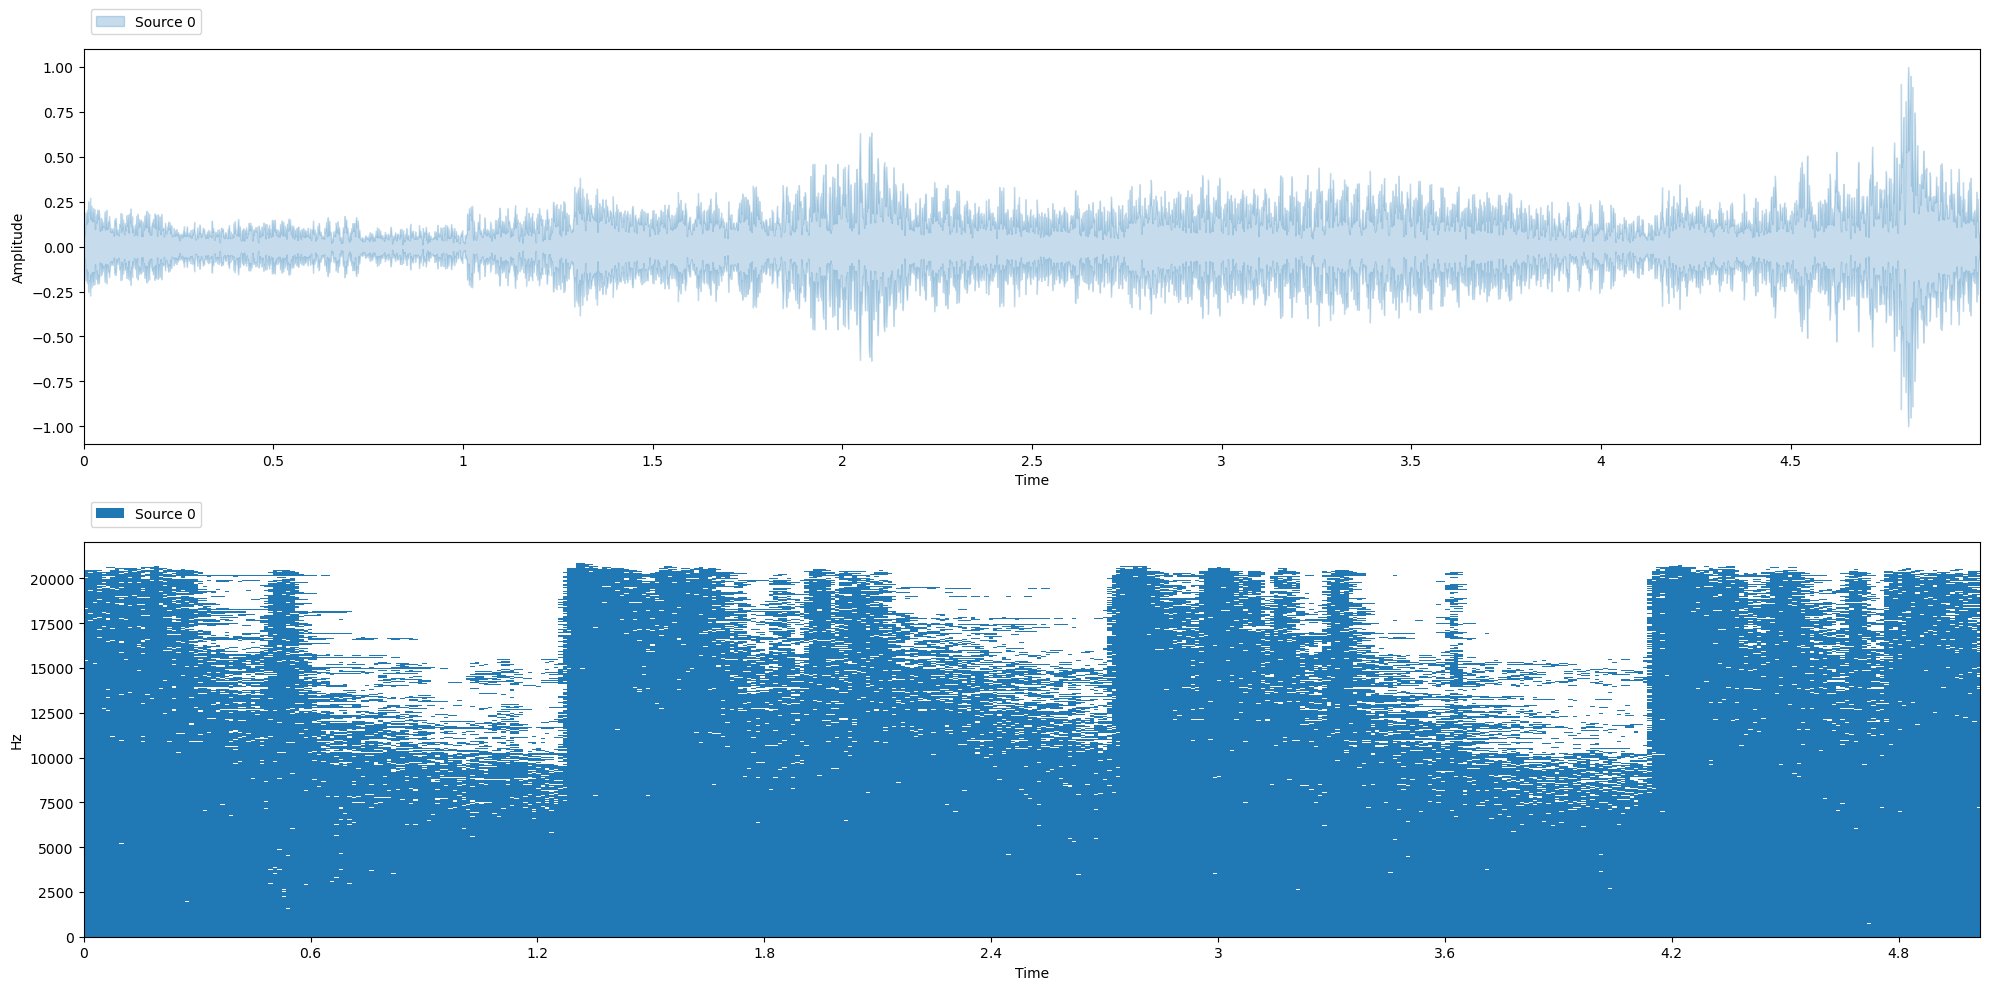


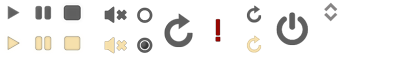
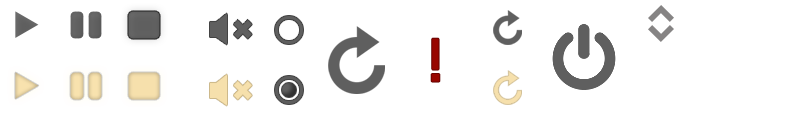
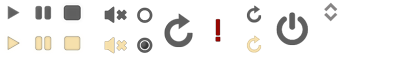

In [36]:
viz.show_sources([item['mix']])

In [ ]:
item = batch['mix_audio']
item = representation(item)
item = amplitude_to_db(item)

In [ ]:
item.shape

In [ ]:
#trainer.run(train_dataloader, **configs['train_params'])